In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline 

In [3]:
import os
import pickle
from glob import glob

import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

#from scipy.optimize import lsq_linear
#from sklearn.linear_model import LinearRegression

matplotlib.rcParams.update({'font.size': 18, 'figure.facecolor':'white', 'figure.figsize':(8, 8)})

%cd /home/naodell/work/hgcal/ECONAutoencoderStudy

/home/naodell/work/hgcal/ECONAutoencoderStudy


In [4]:
# get the data
input_file = open('data/output_0.pkl', 'rb')
data_dict = pickle.load(input_file)
df_tc = data_dict['tc']
df_gen = data_dict['gen']
df_clusters = data_dict['Threshold0']

# hack to find the coordinates of wafers: should do this with a lot more hits or find the official geometry file with coordinates
df_wafer_coords = df_tc.query('tc_z > 0 and tc_subdet == 1').groupby(['tc_waferu', 'tc_waferv']).mean()[['tc_x', 'tc_y']]

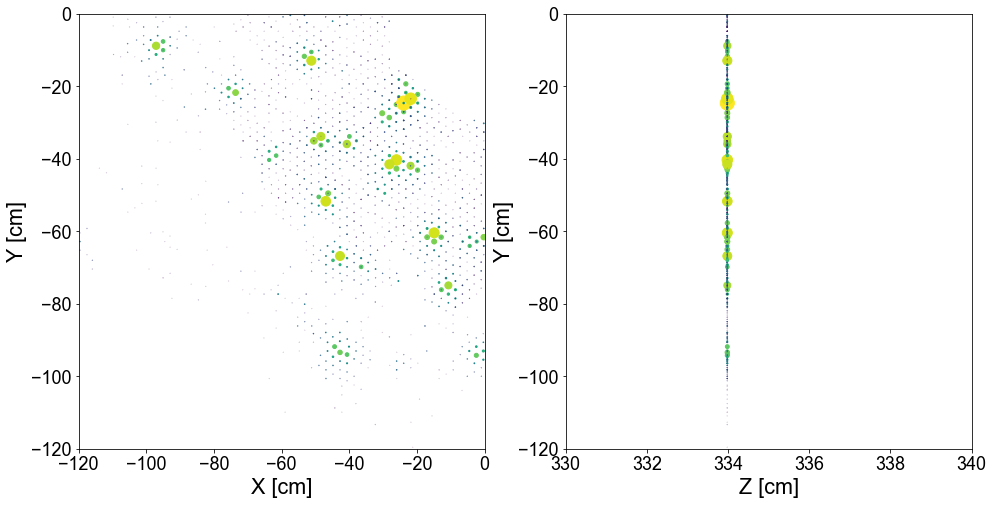

In [9]:
# make some basic plots
fig, axes = plt.subplots(1, 2, facecolor='white', figsize=(16, 8))

cuts = 'tc_z > 0 and tc_x < 0. and tc_y < 0. and tc_subdet == 1 and tc_layer == 9'
event_ix = df_tc.index[0][0]
event_tc = df_tc.query(cuts)
event_cluster = df_clusters.loc[event_ix]
event_gen = df_gen.loc[event_ix]

ax = axes[0]
ax.scatter(event_tc.tc_x, event_tc.tc_y, s=event_tc.tc_energy, c=np.log(event_tc.tc_energy))
ax.set_xlim(-120, 0)
ax.set_ylim(-120, 0)
ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')


#x, y = np.linspace(-100, 100, 50), np.linspace(-100, 100, 50)
#X, Y = np.mgrid[-100:100:5, -100:100:5]
#ax.scatter(X, Y, marker='h', s=70, alpha=0.5)

ax = axes[1]
ax.scatter(event_tc.tc_z, event_tc.tc_y, s=event_tc.tc_energy, c=np.log(event_tc.tc_energy))
ax.set_xlim(330, 340)
ax.set_ylim(-120, 0)
ax.set_xlabel('Z [cm]')
ax.set_ylabel('Y [cm]')

plt.show()

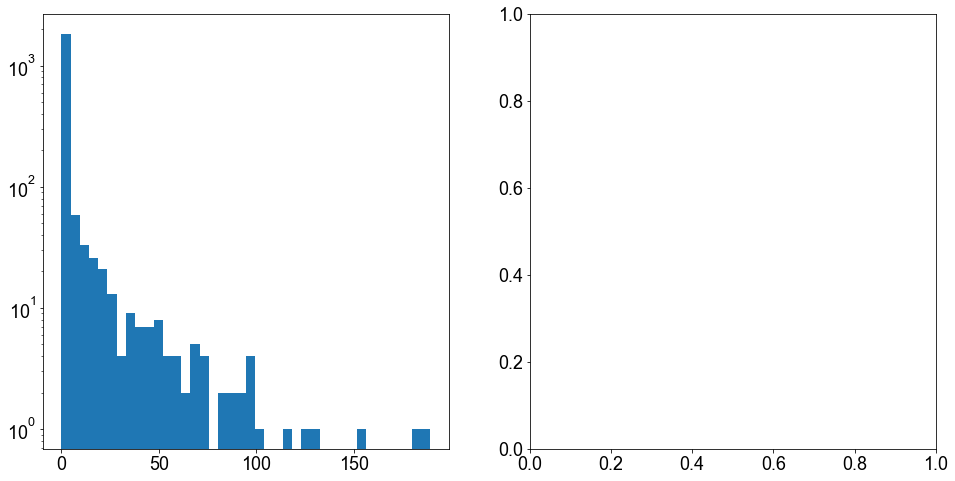

In [28]:
# make some basic plots
fig, axes = plt.subplots(1, 2, facecolor='white', figsize=(16, 8))

ax = axes[0]
ax.hist(event_tc.query('tc_simenergy > 0.1').tc_simenergy, bins=40)
ax.set_yscale('log')
#ax.set_xlim(320, 365)

ax = axes[1]
#ax.hist(

plt.show()

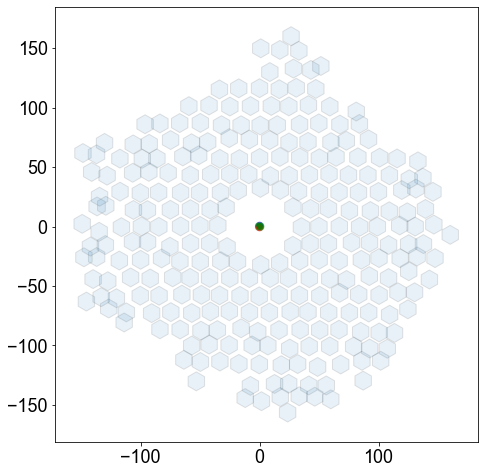

In [19]:
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
import numpy as np

coord = [[0, 0, 0], [0, 1, -1], [-1, 1, 0], [-1, 0, 1], [0, -1, 1], [1, -1, 0], [1, 0, -1]]
colors = [["Green"], ["Blue"], ["Green"], ["Green"], ["Red"], ["Green"], ["Green"]]
labels = [['yes'], ['no'], ['yes'], ['no'], ['yes'], ['no'], ['no']]

# Horizontal cartesian coords
hcoord = [c[0] for c in coord]

# Vertical cartersian coords
vcoord = [2. * np.sin(np.radians(60)) * (c[1] - c[2]) /3. for c in coord]

fig, ax = plt.subplots(1)
ax.set_aspect('equal')

# Add some coloured hexagons

#hcoord, vcoord = df_wafer_coords.values
#for x, y, c, l in zip(hcoord, vcoord, colors, labels):
#for u, v, x, y in df_wafer_coords.iterrows():
for x, y in df_wafer_coords.values:
    #color = c[0].lower()  # matplotlib understands lower case words for colours
    poly = RegularPolygon((x, y), 
                         numVertices=6, 
                         radius=8, 
                         orientation=np.radians(0), 
                         #facecolor=color, 
                         alpha=0.1, 
                         edgecolor='k'
                        )
    ax.add_patch(poly)
    # Also add a text label
    #ax.text(x, y+0.2, l[0], ha='center', va='center', size=20)

# Also add scatter points in hexagon centres
ax.scatter(hcoord, vcoord, c=[c[0].lower() for c in colors], alpha=0.5)

plt.show()